Default: 2543
{'backbone': 2, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 0, 'extract': 0, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 0, 'rephase': 0, 'restart': 1, 'stable': 0, 'substitute': 0, 'sweep': 0, 'target': 0, 'transitive': 1, 'vivify': 1, 'warmup': 0}: 210
{'backbone': 2, 'bump': 1, 'chrono': 0, 'congruence': 1, 'eliminate': 1, 'extract': 0, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 1, 'phase': 0, 'phasesaving': 1, 'preprocess': 0, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 2, 'rephase': 1, 'restart': 1, 'stable': 0, 'substitute': 1, 'sweep': 1, 'target': 0, 'transitive': 1, 'vivify': 1, 'warmup': 1}: 91
{'backbone': 0, 'bump': 1, 'chrono': 1, 'congruence': 1, 'eliminate': 1, 'extract': 0, 'factor': 1, 'fastel': 0, 'forward': 1, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'preprocess': 0, 'probe': 1, 'randec': 1, 'reluctant': 1, 'reorder': 0, 'r

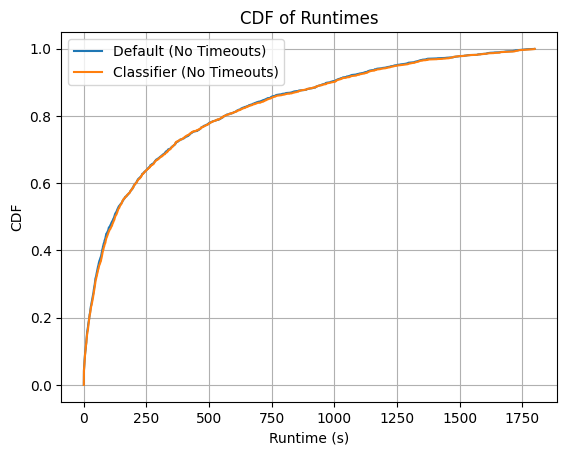

Default timeouts: 1362
Classifier timeouts: 1356


In [1]:
import numpy as np


def parseDefault(filename : str) -> dict:
    with open(filename, 'r') as file:
        insts = {}
        for line in file:
            #if line.startswith("(")
            if line.startswith("TIMEOUT"):
                #print(line)
                instance = line.split("/")[-1].split("-")[0]
                #print(instance)
                insts[instance] = 3600.0

            elif line.startswith("Instance"):
                instance = line.split("/")[-1].split("-")[0]
                time = line.split(" ")[-2]
                #print(instance)
                #print(float(time))
                insts[instance] = float(time)
        return insts

def parseClass(filename : str) -> dict:
    with open(filename, 'r') as file:
        insts = {}
        configs = {}
        for line in file:
            if line.startswith("Instance"):
                instance = line.split(" ")[1]
                time = line.split(" ")[-2]
                if "{" in line and "}" in line:
                    config = line[line.find("{"):line.find("}")+1]
                    #print(config)
                else:
                    config = "Default"
                insts[instance] = float(time)
                if config in configs.keys():
                    configs[config] += 1
                else:
                    configs[config] = 1
        for c, i in configs.items():
            print(c + ": " + str(i))
        return insts

default = parseDefault("./anni.out").values()
classifier = parseClass("./minhitk9.corrected").values()

default = sorted(default)
classifier = sorted(classifier)

import matplotlib.pyplot as plt

# Filter out timeouts from default and classifier
default_no_timeouts = [time for time in default if time < 3600]
classifier_no_timeouts = [time for time in classifier if time < 3600]

# Calculate CDF for default without timeouts
default_no_timeouts_cdf = np.arange(len(default_no_timeouts)) / float(len(default_no_timeouts))

# Calculate CDF for classifier without timeouts
classifier_no_timeouts_cdf = np.arange(len(classifier_no_timeouts)) / float(len(classifier_no_timeouts))

# Plot CDFs without timeouts
plt.plot(default_no_timeouts, default_no_timeouts_cdf, label="Default (No Timeouts)")
plt.plot(classifier_no_timeouts, classifier_no_timeouts_cdf, label="Classifier (No Timeouts)")

# Calculate CDF for default
#default_cdf = np.arange(len(default)) / float(len(default))

# Calculate CDF for classifier
#classifier_cdf = np.arange(len(classifier)) / float(len(classifier))


# Add labels, legend, and title
plt.xlabel("Runtime (s)")
plt.ylabel("CDF")
plt.title("CDF of Runtimes")
plt.legend()

# Show plot
plt.grid()
plt.show()

# Count instances that timed out in default
default_timeouts = sum(1 for time in default if time == 3600)

# Count instances that timed out in classifier
classifier_timeouts = sum(1 for time in classifier if time == 3600)

print(f"Default timeouts: {default_timeouts}")
print(f"Classifier timeouts: {classifier_timeouts}")

In [2]:
import pandas as pd

def locConfig(c):
    df = pd.read_csv('../classifier/classifier/top40.csv')
    df = df.groupby('configuration')['time'].sum()

    configs = df.keys().tolist()
    index = configs.index(c)
    return index

with open("minhitk9.corrected", 'r') as file:
        configs = {}
        for line in file:
            if line.startswith("Instance"):
                if "{" in line and "}" in line:
                    config = line[line.find("{"):line.find("}")+1]
                    #print(config)
                else:
                    config = "Default"
                if config in configs.keys():
                    configs[config] += 1
                else:
                    configs[config] = 1
        for c, i in sorted(configs.items(), key=lambda item: item[1], reverse=True):
            print(str(locConfig(c)) + " & " + str(i) + " \\\\")
        


0 & 2543 \\
9 & 288 \\
27 & 210 \\
21 & 206 \\
25 & 91 \\
29 & 67 \\
6 & 28 \\
7 & 17 \\


In [3]:
from gbd_core.api import GBD
import pandas as pd

def get_prediction_dataset(target, query):
    with GBD([ '/home/raphael-zipperer/Uni/BA/database/base.db', '/home/raphael-zipperer/Uni/BA/database/meta.db' ]) as gbd:
        df = gbd.query(query, resolve=[target])

        return df


data_holdout = get_prediction_dataset("family", 'track=anni_2022 and (track!=main_2023 and track!=main_2024) and minisat1m!=yes')
data_train = get_prediction_dataset("family", '(track=main_2023 or track=main_2024) and minisat1m!=yes')

pd.set_option('display.max_rows', None)
family_counts_holdout = data_holdout['family'].value_counts()
family_counts_train = data_train['family'].value_counts()
family_counts = pd.DataFrame({
    'Holdout': family_counts_holdout,
    'Train': family_counts_train
}).fillna(0).astype(int)
#print(family_counts)

family_counts20 = family_counts[family_counts['Holdout'] > 20]


In [ ]:
import pandas as pd

results_classifier = pd.DataFrame(list(parseClass("minhitk9.corrected").items()), columns=['hash', 'time'])
results_default = pd.DataFrame(list(parseDefault("anni.out").items()), columns=['hash', 'time'])

print(family_counts20.index.unique().tolist())
results = []

for family in family_counts20.index.unique().tolist():
    hashes = data_holdout[data_holdout['family'] == family]['hash'].tolist()
    
    time_classifier = results_classifier[results_classifier['hash'].isin(hashes)]['time'].sum()
    time_default = results_default[results_default['hash'].isin(hashes)]['time'].sum()
    
    results.append({
        "Family": family,
        "Classifier": int(time_classifier / len(hashes)),
        "Default": int(time_default / len(hashes)),
        "Training Instances": family_counts.loc[family, 'Train'],
        "Holdout Instances": len(hashes)

    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Training Instances", ascending=False)
#print(results_df)

for family in results_df["Family"].tolist():
    row = results_df[results_df["Family"] == family].iloc[0].to_dict()
    print(f'{row["Family"]} & '
      f'{"\\textbf{" + row["Classifier"] + "}" if row["Classifier"] < row["Default"] else row["Classifier"]} & '
      f'{"\\textbf{" + row["Default"] + "}" if row["Default"] < row["Classifier"] else row["Default"]} & '
      f'{row["Training Instances"]} & {row["Holdout Instances"]} \\\\')



Default: 2543
{'backbone': 2, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 0, 'extract': 0, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 0, 'rephase': 0, 'restart': 1, 'stable': 0, 'substitute': 0, 'sweep': 0, 'target': 0, 'transitive': 1, 'vivify': 1, 'warmup': 0}: 210
{'backbone': 2, 'bump': 1, 'chrono': 0, 'congruence': 1, 'eliminate': 1, 'extract': 0, 'factor': 0, 'fastel': 1, 'forward': 0, 'lucky': 1, 'phase': 0, 'phasesaving': 1, 'preprocess': 0, 'probe': 1, 'randec': 0, 'reluctant': 0, 'reorder': 2, 'rephase': 1, 'restart': 1, 'stable': 0, 'substitute': 1, 'sweep': 1, 'target': 0, 'transitive': 1, 'vivify': 1, 'warmup': 1}: 91
{'backbone': 0, 'bump': 1, 'chrono': 1, 'congruence': 1, 'eliminate': 1, 'extract': 0, 'factor': 1, 'fastel': 0, 'forward': 1, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'preprocess': 0, 'probe': 1, 'randec': 1, 'reluctant': 1, 'reorder': 0, 'r